In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas as pd
import contextily as ctx
from mplcairo import operator_t
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patheffects
import cartopy.crs as ccrs
import numpy as np
from math import floor
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

mpl.rc('font', family='DejaVu Sans')

In [2]:
def get_bins(df, column, k=5):
    min_v = df[column].min()
    max_v = df[column].max()

    array = []
    
    for i in range(k+1):
        step = max_v/(k+1)
        array.append(round(step*(i+1), 0))
    return array
def get_quantiles(df, column, k=5):
    step = 1/k
    quantiles = []
    for i in range(k+1):
        quantile_at_step = df[column].quantile(step*i)
        quantiles.append(quantile_at_step)
    return quantiles

In [3]:
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
limite_mun = gpd.read_file('./data/BASES/limite_municipio/limite_municipio.shp')
lotes_empreendimentos = gpd.read_file('./data/BASES/empreendimento/empreendimento.shp')
populacao_bairros = gpd.read_file('./data/POPULACAO/bairros.shp')
populacao_setores = gpd.read_file('./data/POPULACAO/setores_recorte.shp')

limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")

recorte_maior = recorte_maior.to_crs(epsg=3857)
recorte_menor = recorte_menor.to_crs(epsg=3857)
limite_mun = limite_mun.to_crs(epsg=3857)
populacao_setores = populacao_setores.to_crs(epsg=3857)
populacao_bairros = populacao_bairros.to_crs(epsg=3857)
lotes_empreendimentos = lotes_empreendimentos.to_crs(epsg=3857)




In [4]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.15, 0.075), linewidth=3,
              units='km', m_per_unit=1000):

    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.02
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
     #Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
                linewidth=linewidth, zorder=3)

In [45]:
def crop(ax, factor_top, factor_right, factor_bottom, factor_left): 
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    #example of how to zoomout by a factor of 0.1
    
    new_lim_left = (xlim[0] + xlim[1])/2 + np.array((-0.5, 0.5)) * (xlim[1] - xlim[0]) * (factor_left) 
    new_lim_right = (xlim[0] + xlim[1])/2 + np.array((-0.5, 0.5)) * (xlim[1] - xlim[0]) * (factor_right) 
    new_lim_bottom = (ylim[0] + ylim[1])/2 + np.array((-0.5, 0.5)) * (ylim[1] - ylim[0]) * (factor_bottom)
    new_lim_top = (ylim[0] + ylim[1])/2 + np.array((-0.5, 0.5)) * (ylim[1] - ylim[0]) * (factor_top)

    new_lim_left = tuple(new_lim_left)
    new_lim_right = tuple(new_lim_right)
    new_lim_top = tuple(new_lim_top)
    new_lim_bottom = tuple(new_lim_bottom)
    
    new_ylim = (new_lim_bottom[0], new_lim_top[1])
    new_xlim = (new_lim_left[0], new_lim_right[1])
        
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)

In [69]:
def plot_categorical(df, 
                     column,
                     k,
                     alpha,
                     borders, 
                     output, 
                     annotation_pos_1, 
                     annotation_pos_2, 
                     annotation_pos_3, 
                     zoom, 
                     legend_title, 
                     scale_extension=1,
                     factor_top=1,
                     factor_right=1,
                     factor_bottom=1, 
                     factor_left=1,
                    legend_y = 0.07):

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#ffffff'
    plt.rcParams['figure.edgecolor'] = 'red'
    mpl.rcParams['legend.facecolor'] = '#ffffff'
    mpl.rcParams['figure.edgecolor'] = 'black'
    mpl.rcParams['legend.loc'] = 'lower center'


    fig = plt.figure(figsize = (15,15))
    gs1 = gridspec.GridSpec(2, 1, height_ratios=[10, 0.5])
    gs1.update(wspace=0.01, hspace=0.01)
    ax = plt.subplot(gs1[0], projection = ccrs.epsg(3857))
    cax = plt.subplot(gs1[1])
    plt.subplots_adjust(wspace=0, hspace=0)
    ax.set_facecolor('none')
    ax.set_axis_off()


    plot = df.plot(ax=ax,
                   column=column,
                   cmap='viridis_r',
                   linewidth=1,
                   scheme='quantiles', 
                   k=k,
                   edgecolor='#FFFFFF',
                   alpha=alpha,
                   zorder=1)

    crop(ax, factor_top, factor_right, factor_bottom, factor_left)
    
    cmap = mpl.cm.viridis.reversed()
    divider = make_axes_locatable(ax)


    bins = get_bins(df, column, k=k)

    norm = mpl.colors.BoundaryNorm(bins, cmap.N)



    for i, border in enumerate(borders):
            border_plot = border.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=(0.6+(i+1/2)), linestyle='--')

    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=zoom, alpha = 0.2, attribution="", zorder=0)


    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legend_elements = []
    legend_elements = [Line2D([0], [0], color='#2BBDCC', lw=2, label='Novos Empreendimentos', linestyle='--')]

    # Create the figure
    ax.legend(handles=legend_elements, loc='lower left')

    scale_bar(ax, ccrs.epsg(3857), scale_extension)


    plt.annotate('Fonte: IBGE - Censo 2010', (0,0), (600, 95), xycoords='axes fraction', textcoords='offset points', va='center')
    plt.annotate('Base Cartográfica por Stamen Design', (0,0), (600, 80), xycoords='axes fraction', textcoords='offset points', va='center')

    #cax = divider.append_axes("bottom", size="5%", pad=0.05)
    #plt.tight_layout(pad=0)

    cb = mpl.colorbar.ColorbarBase(ax=cax,
                                   cmap=cmap,
                                   norm=norm,
                                   spacing='uniform',
                                   orientation='horizontal',
                                   extend='neither',
                                   ticks=bins,
                                   drawedges=True,
                                   alpha=alpha)
    cb.outline.set_edgecolor('#ffffff')
    cb.dividers.set_linewidth(3)

    pos1 = cax.get_position() # get the original position 
    pos2 = [pos1.x0 +0.004, pos1.y0 + legend_y,  pos1.width, pos1.height] 
    cax.set_position(pos2) # set a new position
    cax.tick_params(colors="none")
    plt.setp(cax.get_xticklabels(), color="black")

    plt.annotate(legend_title, (0,0), annotation_pos_3, xycoords='axes fraction', textcoords='offset points', va='center')

    empreendimentos_plot = lotes_empreendimentos.plot(ax=ax,
                                                      facecolor='none',
                                                      edgecolor='tab:cyan',
                                                      linewidth=(2.5),
                                                      linestyle='--',
                                                      zorder=5)
    #operator_t.MULTIPLY.patch_artist(plot)
    #operator_t.SOURCE.patch_artist(empreendimentos_plot)

    plt.savefig('OUTPUT' + output+'.pdf')
    plt.savefig('OUTPUT' + output+'.png')


    plt.show()

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f41ea7c4680> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '
<ipython-input-61-eb75e6241a69>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


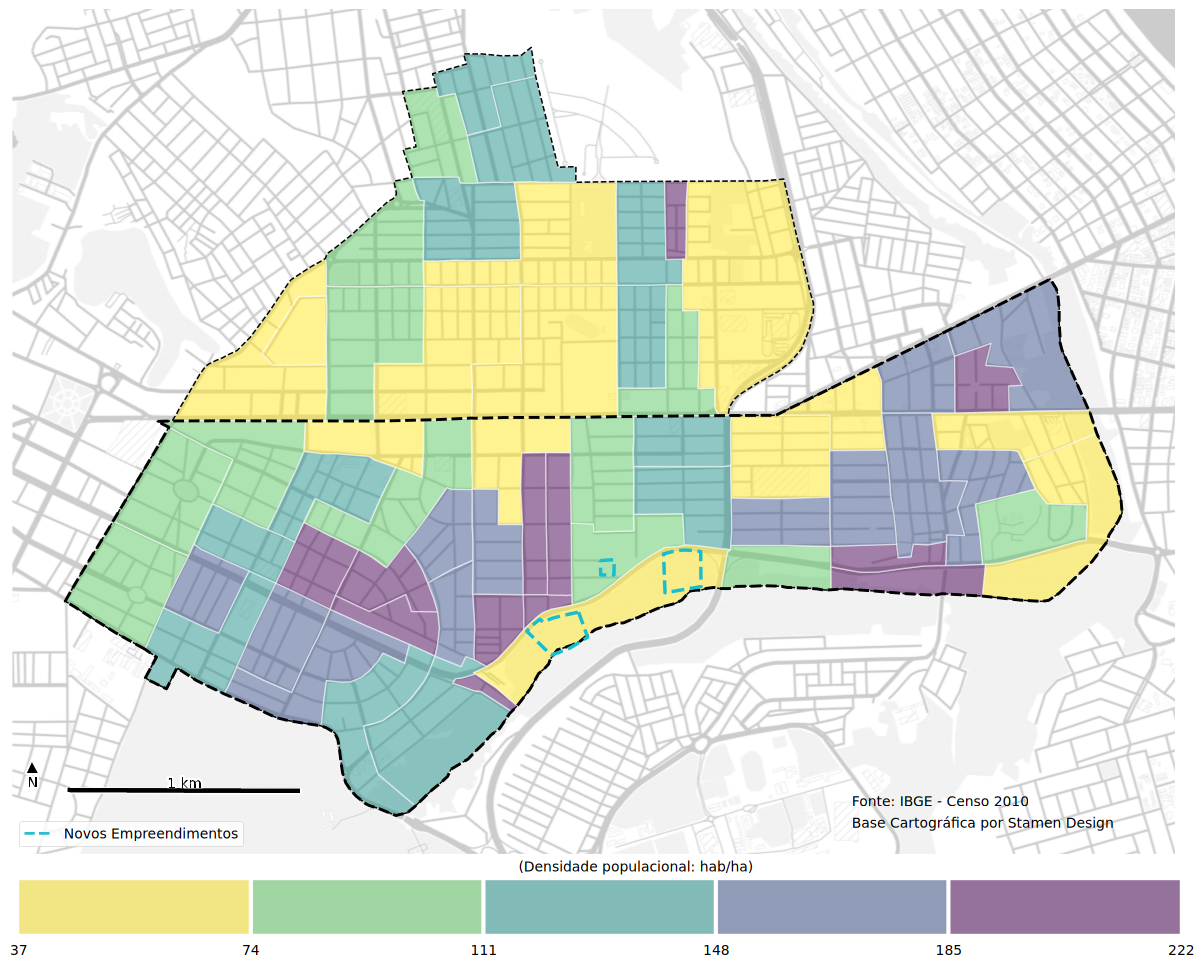

In [62]:
borders = [recorte_maior, recorte_menor]
plot_categorical(populacao_setores, 
                 'densidade',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor], 
                 'densidade_populacional_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f41ea8dac20> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


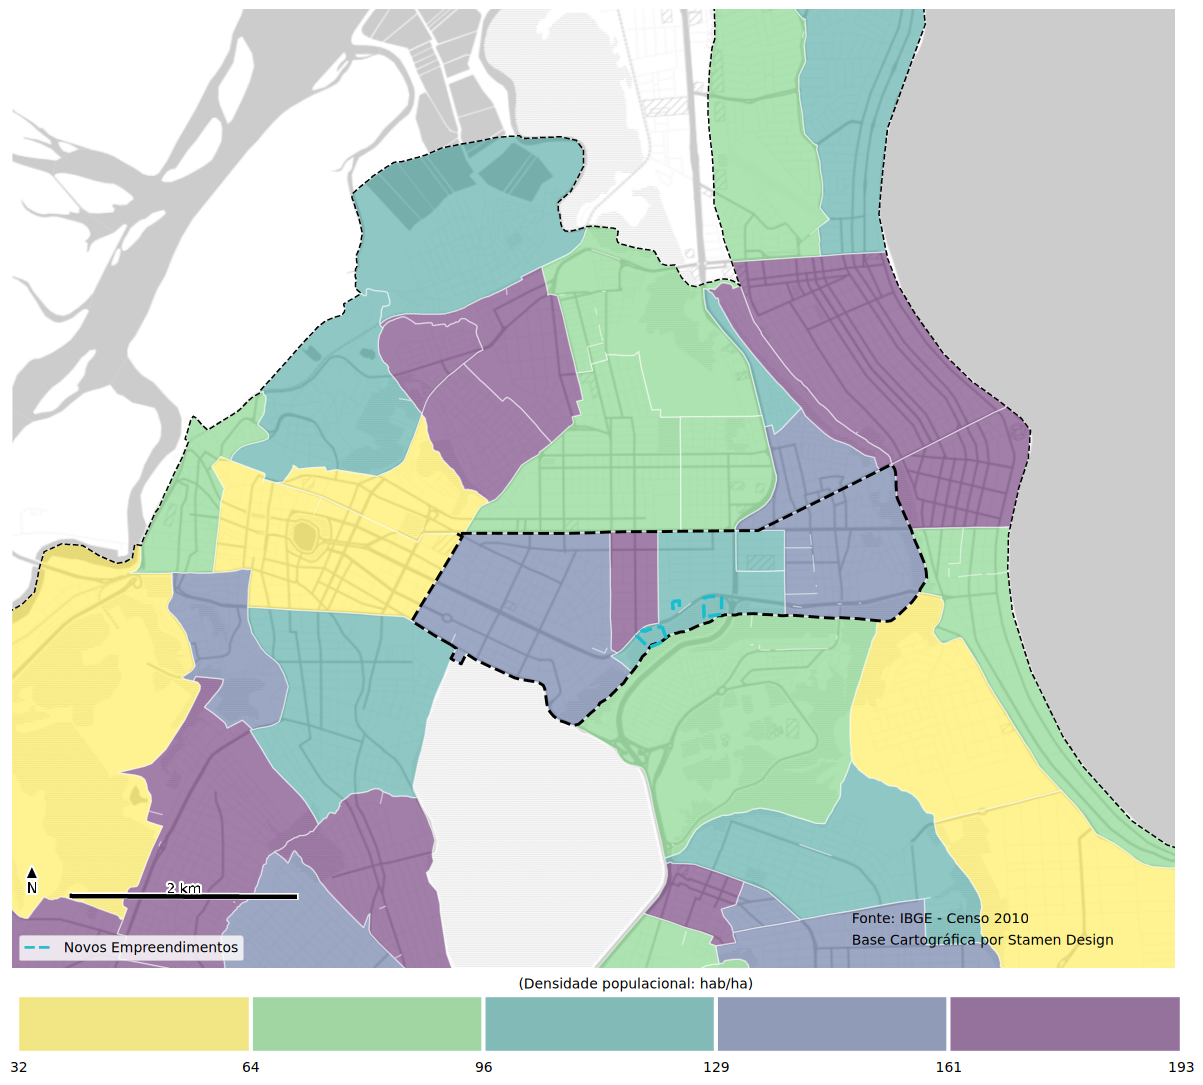

In [74]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],                 
                 'densidade_populacional_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f41ea7d1ef0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


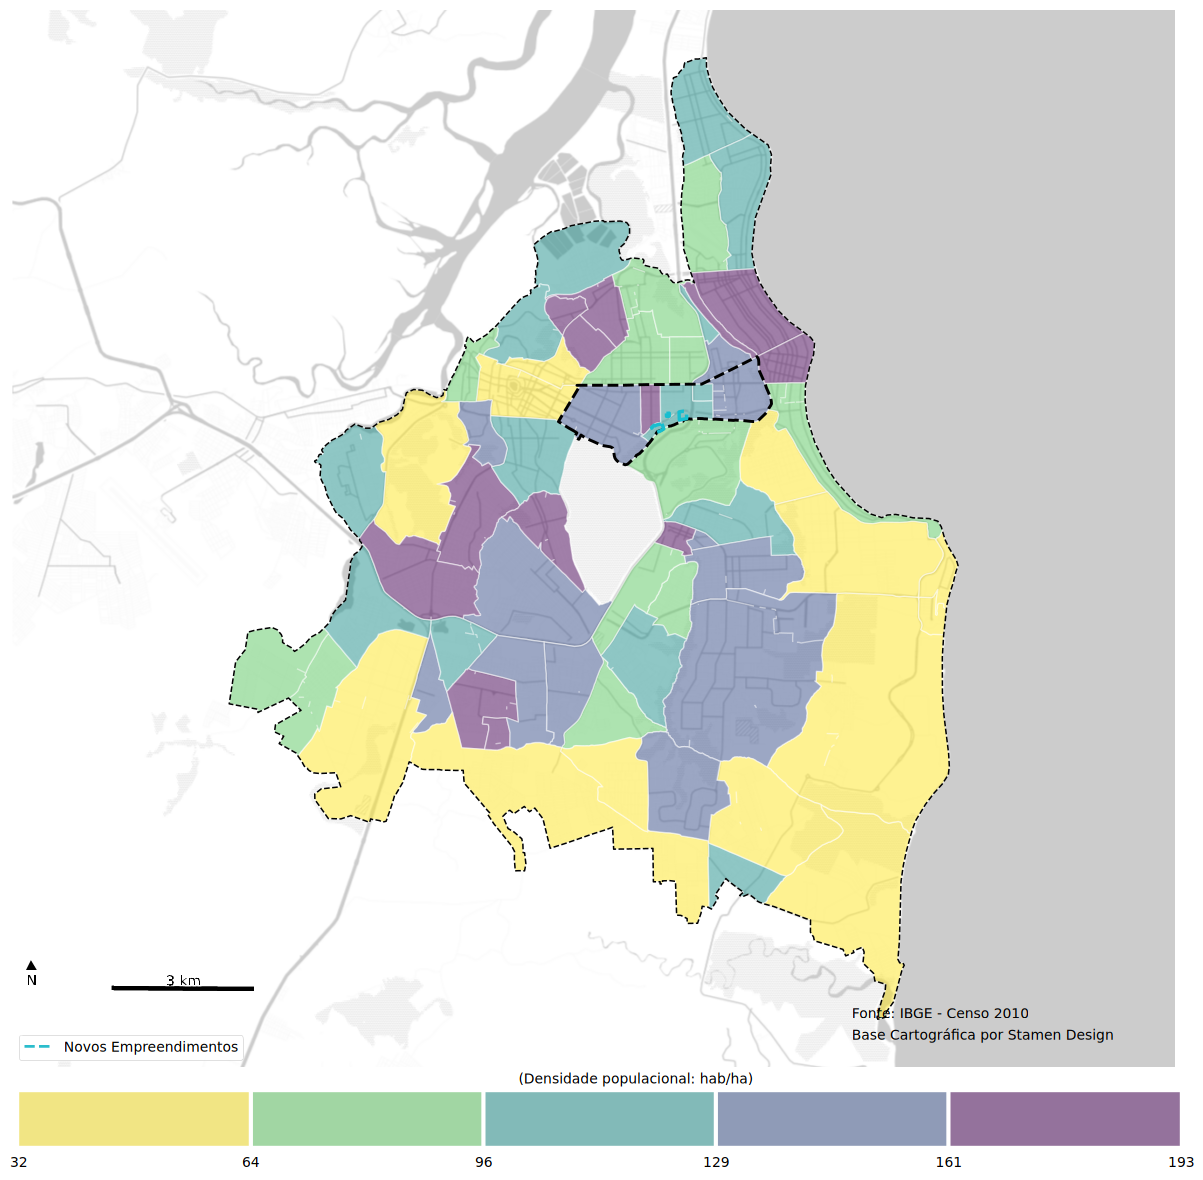

In [82]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],                 
                 'densidade_populacional_cidade', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 13, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1,
                 factor_top=1)